In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from toolkit import filepath_to_csv, Orchids_filepath_to_csv

In [2]:
filepaths = [
    "round-4-island-data-bottle\prices_round_4_day_1.csv",
    "round-4-island-data-bottle\prices_round_4_day_2.csv",
    "round-4-island-data-bottle\prices_round_4_day_3.csv",
]
dfs = []
for filepath in filepaths:
    df = filepath_to_csv(filepath)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df['total_time'] = (df['day'] - 1)* 1000000 + df['timestamp']

# what happened at day 2 9716?

In [3]:
coco = df[df['product'] == 'COCONUT'].reset_index()
dte = df[df['product'] == 'COCONUT_COUPON'].reset_index()

In [4]:
coco.mid_price.mean(), dte.mid_price.mean()

(9999.900983333333, 635.0464333333333)

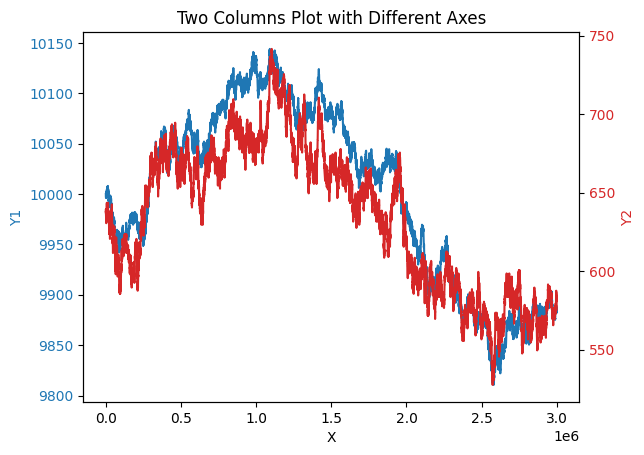

In [5]:
def graph_trends(df1, df2, col1, col2):
    fig, ax1 = plt.subplots()

    # Plotting the first data on the left axis
    color = 'tab:blue'
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y1', color=color)
    ax1.plot(df1['total_time'], df1[col1], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Creating a second y-axis and plotting the second data
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Y2', color=color)
    ax2.plot(df2['total_time'], df2[col2], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Two Columns Plot with Different Axes')
    plt.show()
graph_trends(coco, dte, 'mid_price', 'mid_price')

In [6]:
coco1 = coco[coco.day == 1]
coco2 = coco[coco.day == 2]
coco3 = coco[coco.day == 3]

In [7]:
dte1 = dte[dte.day == 1]
dte2 = dte[dte.day == 2]
dte3 = dte[dte.day == 3]

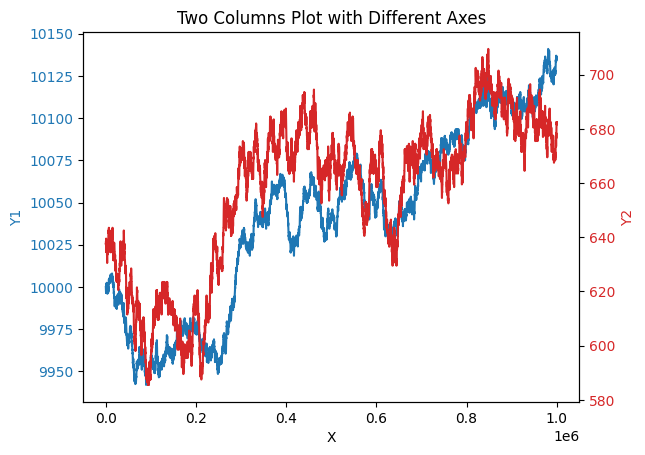

In [324]:
graph_trends(coco1[coco1.timestamp < 1000000], dte1[dte1.timestamp < 1000000], 'mid_price', 'mid_price')

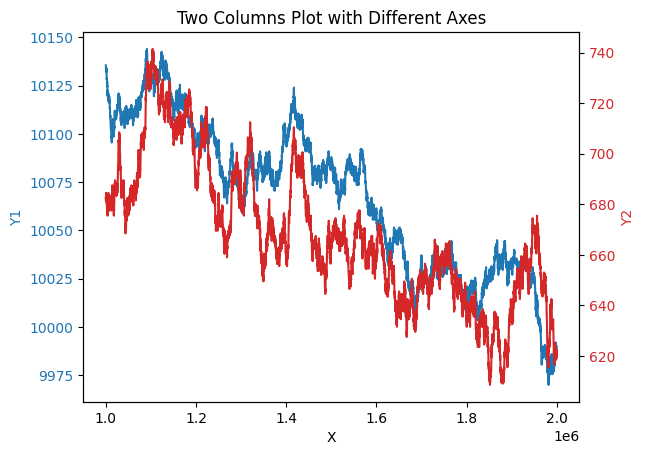

In [325]:
graph_trends(coco2, dte2, 'mid_price', 'mid_price')

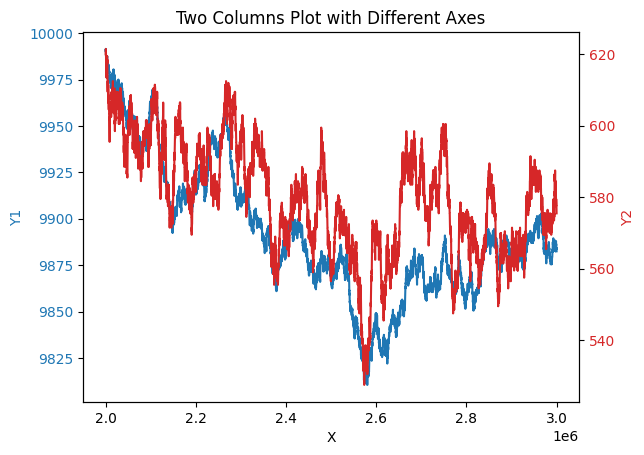

In [326]:
graph_trends(coco3, dte3, 'mid_price', 'mid_price')

In [327]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import newton

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility(option_price, S, K, T, r, initial_guess=0.1):
    # Define a function that returns the difference between the option price
    # calculated using the Black-Scholes formula and the actual option price
    def difference(sigma):
        return black_scholes_call(S, K, T, r, sigma) - option_price

    # Use Newton-Raphson method to find the root (implied volatility)
    implied_vol = newton(difference, initial_guess)
    return implied_vol
n = coco.shape[0]
# Example DataFrame
df = pd.DataFrame({
    'day': coco.day,
    'Time_Stamp': coco.timestamp,
    'Stock_Price': coco.mid_price,
    'Option_Price': dte.mid_price,
    'Time_to_Expiry': [250/252] * n,
    'Risk_Free_Rate': [0] * n,
    'Strike_Price': [10000] * n
})

# Calculate implied volatility for each row
df['Implied_Volatility'] = df.apply(lambda row: implied_volatility(row['Option_Price'], 
                                                                   row['Stock_Price'], 
                                                                   row['Strike_Price'], 
                                                                   row['Time_to_Expiry'], 
                                                                   row['Risk_Free_Rate']), axis=1)

In [328]:
df['time'] = df['Time_Stamp'] + (df['day'] - 1) * 1000000
df

,day,Time_Stamp,Stock_Price,Option_Price,Time_to_Expiry,Risk_Free_Rate,Strike_Price,Implied_Volatility,time
0,1,0,10000.0,637.5,0.992063,0,10000,0.160607,0
1,1,100,9999.5,637.5,0.992063,0,10000,0.160674,100
2,1,200,9998.5,637.5,0.992063,0,10000,0.160808,200
3,1,300,9999.5,638.5,0.992063,0,10000,0.160926,300
4,1,400,9998.5,637.5,0.992063,0,10000,0.160808,400
...,...,...,...,...,...,...,...,...,...
29995,3,999500,9883.5,577.5,0.992063,0,10000,0.160675,2999500
29996,3,999600,9884.5,577.5,0.992063,0,10000,0.160547,2999600
29997,3,999700,9883.5,575.5,0.992063,0,10000,0.160165,2999700
29998,3,999800,9884.0,575.5,0.992063,0,10000,0.160101,2999800


<Axes: >

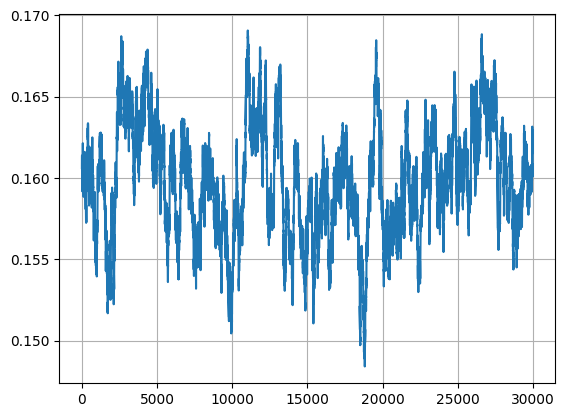

In [329]:
df.Implied_Volatility.plot(grid = True)

In [330]:
def realized_volatility(prices):
    # Calculate logarithmic returns
    log_returns = np.log(prices / prices.shift(10))
    
    # Drop NaN values
    log_returns = log_returns.dropna()
    
    # Calculate realized volatility as the standard deviation of log returns
    volatility = np.sqrt(np.sum(log_returns ** 2) * (252_000 / len(log_returns)))  # Assuming 252 trading days in a year
    
    return volatility

# Calculate realized volatility
realized_vol = realized_volatility(df['Stock_Price'])

realized_vol #* np.sqrt(1_000_000)

0.16103523587865434

In [331]:
df['Log_Return'] = np.log(df['Stock_Price'] / df['Stock_Price'].shift(1))
df['Log_dte'] = np.log(df['Option_Price'] / df['Option_Price'].shift(1))

In [332]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import newton

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def implied_volatility(option_price, S, K, T, r, initial_guess=0.1):
    # Define a function that returns the difference between the option price
    # calculated using the Black-Scholes formula and the observed option price
    def difference(sigma):
        return black_scholes_call(S, K, T, r, sigma) - option_price

    # Use Newton-Raphson method to find the root (implied volatility)
    implied_vol = newton(difference, initial_guess)
    return implied_vol

# Example parameters
S = 10000  # Current stock price
K = 10000  # Strike price
T = 250/252    # Time to expiration (in years)
r = 0 # Risk-free interest rate
option_price = 637.63  # Observed option price

# Calculate implied volatility
implied_vol = implied_volatility(option_price, S, K, T, r)
print("Implied Volatility:", implied_vol)


Implied Volatility: 0.16063937134736464


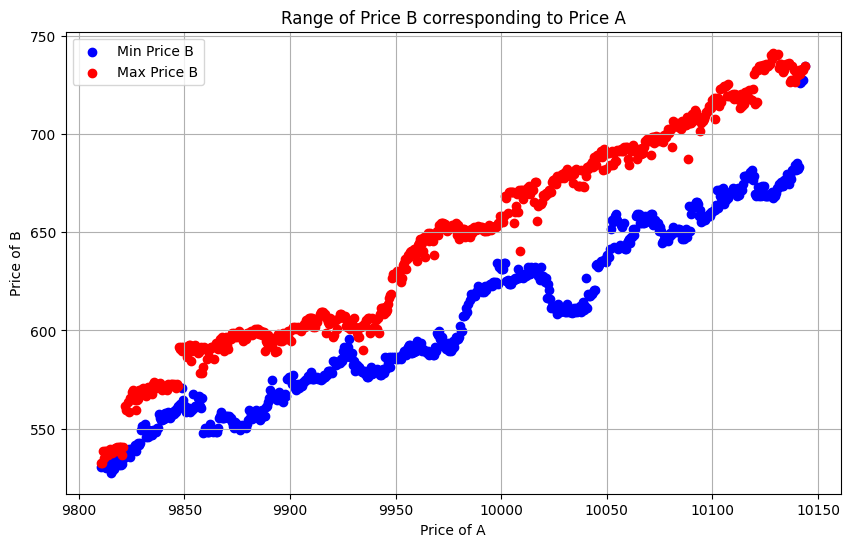

In [333]:
# Group Price_B by Price_A
price_b_grouped = df.groupby('Stock_Price')['Option_Price']

# Calculate the range of values for Price_B corresponding to each Price_A
price_b_min = price_b_grouped.min()
price_b_max = price_b_grouped.max()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(price_b_min.index, price_b_min.values, label='Min Price B', color='blue')
plt.scatter(price_b_max.index, price_b_max.values, label='Max Price B', color='red')
plt.xlabel('Price of A')
plt.ylabel('Price of B')
plt.title('Range of Price B corresponding to Price A')
plt.legend()
plt.grid(True)
plt.show()


In [334]:
df.groupby('Stock_Price')['Option_Price'].agg(['min', 'max'])

,min,max
Stock_Price,,
9810.5,530.5,532.5
9811.0,531.5,532.5
9811.5,531.5,538.5
9812.0,531.5,535.0
9812.5,534.5,538.5
...,...,...
10141.5,726.0,730.5
10142.0,726.5,732.5
10142.5,727.5,733.0


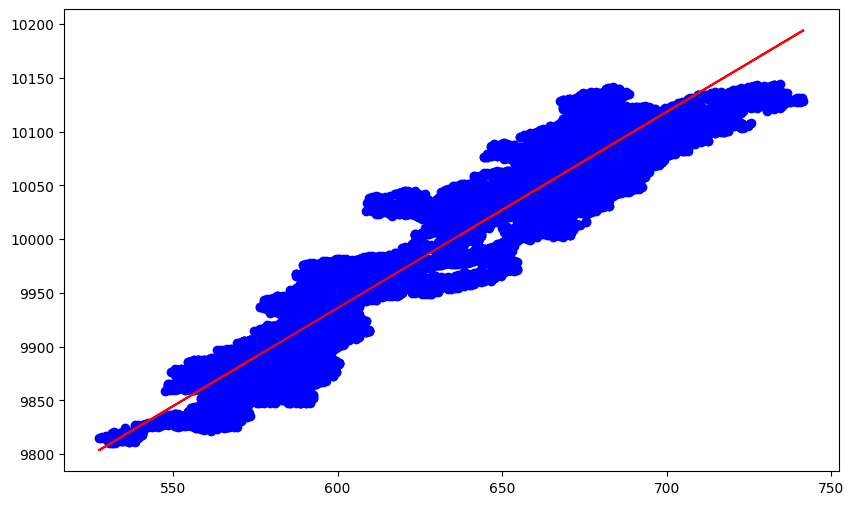

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Stock_Price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 3.337e+05
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:05:39   Log-Likelihood:            -1.3972e+05
No. Observations:               30000   AIC:                         2.794e+05
Df Residuals:                   29998   BIC:                         2.795e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8841.2014      2.011   4395.781      0.000    8837.259    8845.144
Option_Price     1.8246      0.003    577.646      0.000       1.818       1.831
==============================================================================
Omnibus:                      217.434   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.234
Skew:                           0.051   Prob(JB):                     5.32e-34
Kurtosis:                       2.665   Cond. No.                     8.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

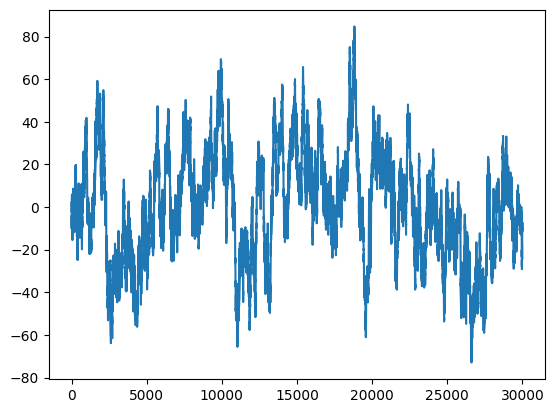

In [335]:
import statsmodels.api as sm

X = sm.add_constant(df['Option_Price'])  # Add a constant term to the predictor
model = sm.OLS(df['Stock_Price'], X).fit()


plt.figure(figsize=(10, 6))
plt.scatter(df['Option_Price'], df['Stock_Price'], label='Data', color='blue')
plt.plot(df['Option_Price'], model.predict(X), color='red', label='Regression Line')
plt.show()
(df['Stock_Price'] - model.predict(X)).plot()
model.summary()

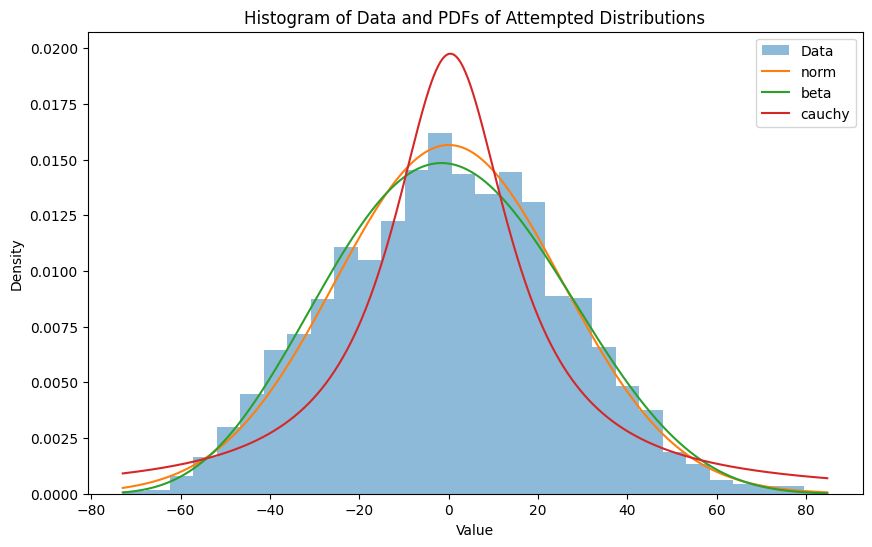

Distribution: norm, Params: (3.233969133968155e-11, 25.4901513184394), KS Statistic: 0.01796055804095903, KS p-value: 7.754668958499365e-09
Distribution: beta, Params: (6.168686192375719, 7.46782956918444, -88.71729383049173, 196.07951129774327), KS Statistic: 0.01679752004090801, KS p-value: 8.77837749553547e-08
Distribution: cauchy, Params: (0.363708032483421, 16.11872655864723), KS Statistic: 0.08151773806670849, KS p-value: 7.330853339387175e-174


In [336]:
distributions = ['norm', 'beta', 'cauchy']
a = df['Stock_Price'] - model.predict(X)
# Fit distributions and calculate goodness-of-fit measures
results = {}

plt.figure(figsize=(10, 6))
plt.hist(a, bins=30, density=True, alpha=0.5, label='Data')

for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(a)
    ks_statistic, ks_p_value = stats.kstest(a, dist_name, args=params)
    results[dist_name] = {'params': params, 'ks_statistic': ks_statistic, 'ks_p_value': ks_p_value}
    
    x = np.linspace(a.min(), a.max(), 1000)
    plt.plot(x, dist.pdf(x, *params), label=dist_name)

plt.legend()
plt.title('Histogram of Data and PDFs of Attempted Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Print results
for dist_name, dist_result in results.items():
    print(f"Distribution: {dist_name}, Params: {dist_result['params']}, KS Statistic: {dist_result['ks_statistic']}, KS p-value: {dist_result['ks_p_value']}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Option_Price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 3.337e+05
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:05:41   Log-Likelihood:            -1.2038e+05
No. Observations:               30000   AIC:                         2.408e+05
Df Residuals:                   29998   BIC:                         2.408e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4393.5047      8.706   -504.676      0.000   -4410.568   -4376.441
Stock_Price     0.5029      0.001    577.646      0.000       0.501       0.505
==============================================================================
Omnibus:                      125.636   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.563
Skew:                           0.088   Prob(JB):                     7.25e-24
Kurtosis:                       2.767   Cond. No.                     1.13e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

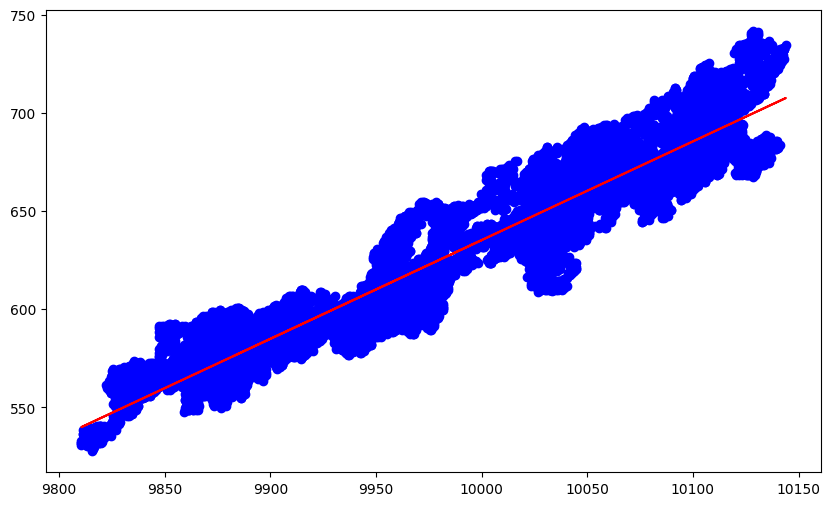

In [337]:
import statsmodels.api as sm

X = sm.add_constant(df['Stock_Price'])  # Add a constant term to the predictor
model = sm.OLS(df['Option_Price'], X).fit()


plt.figure(figsize=(10, 6))
plt.scatter(df['Stock_Price'], df['Option_Price'], label='Data', color='blue')
plt.plot(df['Stock_Price'], model.predict(X), color='red', label='Regression Line')

model.summary()

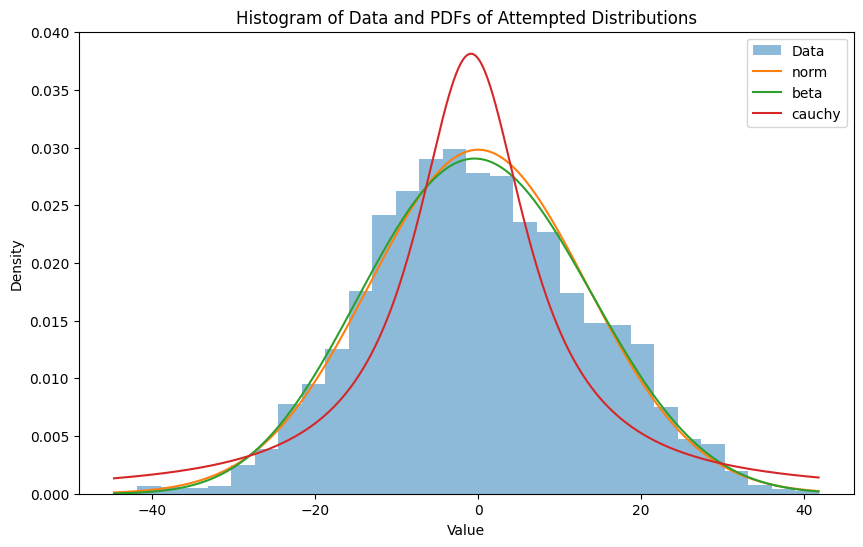

Distribution: norm, Params: (1.154451941450437e-13, 13.381762301052225), KS Statistic: 0.02143550980583403, KS p-value: 2.0925839852594596e-12
Distribution: beta, Params: (12.660461900723785, 14.850506312149145, -65.9433071645465, 143.30003341683596), KS Statistic: 0.016161051707370533, KS p-value: 3.0922495441056014e-07
Distribution: cauchy, Params: (-0.8822271781832448, 8.348146340580737), KS Statistic: 0.0836032346057923, KS p-value: 7.312703675166424e-183


In [338]:
distributions = ['norm', 'beta', 'cauchy']
a = df['Option_Price'] - model.predict(X)
# Fit distributions and calculate goodness-of-fit measures
results = {}

plt.figure(figsize=(10, 6))
plt.hist(a, bins=30, density=True, alpha=0.5, label='Data')

for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(a)
    ks_statistic, ks_p_value = stats.kstest(a, dist_name, args=params)
    results[dist_name] = {'params': params, 'ks_statistic': ks_statistic, 'ks_p_value': ks_p_value}
    
    x = np.linspace(a.min(), a.max(), 1000)
    plt.plot(x, dist.pdf(x, *params), label=dist_name)

plt.legend()
plt.title('Histogram of Data and PDFs of Attempted Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Print results
for dist_name, dist_result in results.items():
    print(f"Distribution: {dist_name}, Params: {dist_result['params']}, KS Statistic: {dist_result['ks_statistic']}, KS p-value: {dist_result['ks_p_value']}")

In [339]:
lr_df = df.iloc[1:]
lr_df

,day,Time_Stamp,Stock_Price,Option_Price,Time_to_Expiry,Risk_Free_Rate,Strike_Price,Implied_Volatility,time,Log_Return,Log_dte
1,1,100,9999.5,637.5,0.992063,0,10000,0.160674,100,-0.000050,0.000000
2,1,200,9998.5,637.5,0.992063,0,10000,0.160808,200,-0.000100,0.000000
3,1,300,9999.5,638.5,0.992063,0,10000,0.160926,300,0.000100,0.001567
4,1,400,9998.5,637.5,0.992063,0,10000,0.160808,400,-0.000100,-0.001567
5,1,500,9996.5,637.5,0.992063,0,10000,0.161076,500,-0.000200,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
29995,3,999500,9883.5,577.5,0.992063,0,10000,0.160675,2999500,-0.000051,0.000000
29996,3,999600,9884.5,577.5,0.992063,0,10000,0.160547,2999600,0.000101,0.000000
29997,3,999700,9883.5,575.5,0.992063,0,10000,0.160165,2999700,-0.000101,-0.003469
29998,3,999800,9884.0,575.5,0.992063,0,10000,0.160101,2999800,0.000051,0.000000


In [340]:
lr_df['Log_dte'].corr(lr_df['Log_Return'].shift(0))

0.43636941086468245

In [341]:
def bs_call(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


In [342]:
def calculate_call_price(row):
    S = row['Stock_Price']
    K = row['Strike_Price']
    r = row['Risk_Free_Rate']
    T = (250_000_000 - row['time']) / 252_000_000
    implied_vol = 0.16063937134736464  # Implied volatility, adjust as needed
    call_price = bs_call(S, K, r, implied_vol, T)
    return call_price

df['Call_Price'] = df.apply(calculate_call_price, axis=1)

<Axes: >

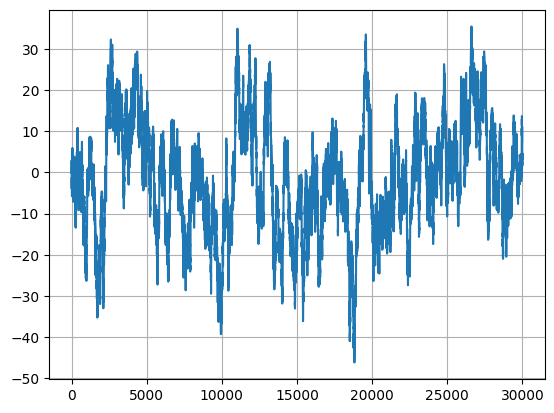

In [343]:
(df.Option_Price - df.Call_Price).plot(grid = True)

In [344]:
def calculate_delta(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def calculate_gamma(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return gamma

def calculate_delta_df(row):
    S = row['Stock_Price']
    K = row['Strike_Price']
    r = row['Risk_Free_Rate']
    T = (250_000_000 - row['time']) / 252_000_000
    implied_vol = 0.16063937134736464  # Implied volatility, adjust as needed
    call_price = calculate_delta(S, K, r, implied_vol, T)
    return call_price

def calculate_delta_df1(row):
    S = row['Stock_Price']
    K = row['Strike_Price']
    r = row['Risk_Free_Rate']
    T = (250_000_000 - row['time']) / 252_000_000
    implied_vol = row['Implied_Volatility']
    call_price = calculate_delta(S, K, r, implied_vol, T)
    return call_price


df['Delta_theo'] = df.apply(calculate_delta_df, axis=1)
df['Delta_real'] = df.apply(calculate_delta_df1, axis=1)


In [345]:
df['returns'] = df['Stock_Price'].pct_change()
df['HV'] = df['returns'].rolling(window=100).std() * np.sqrt(2520000)
df

,day,Time_Stamp,Stock_Price,Option_Price,Time_to_Expiry,Risk_Free_Rate,Strike_Price,Implied_Volatility,time,Log_Return,Log_dte,Call_Price,Delta_theo,Delta_real,returns,HV
0,1,0,10000.0,637.5,0.992063,0,10000,0.160607,0,NaN,NaN,637.630000,0.531882,0.531875,NaN,NaN
1,1,100,9999.5,637.5,0.992063,0,10000,0.160674,100,-0.000050,0.000000,637.363963,0.531757,0.531764,-0.000050,NaN
2,1,200,9998.5,637.5,0.992063,0,10000,0.160808,200,-0.000100,0.000000,636.832203,0.531509,0.531542,-0.000100,NaN
3,1,300,9999.5,638.5,0.992063,0,10000,0.160926,300,0.000100,0.001567,637.363709,0.531757,0.531814,0.000100,NaN
4,1,400,9998.5,637.5,0.992063,0,10000,0.160808,400,-0.000100,-0.001567,636.831948,0.531509,0.531542,-0.000100,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,3,999500,9883.5,577.5,0.992063,0,10000,0.160675,2999500,-0.000051,0.000000,573.565619,0.502328,0.502342,-0.000051,0.150125
29996,3,999600,9884.5,577.5,0.992063,0,10000,0.160547,2999600,0.000101,0.000000,574.067947,0.502582,0.502547,0.000101,0.147609
29997,3,999700,9883.5,575.5,0.992063,0,10000,0.160165,2999700,-0.000101,-0.003469,573.565365,0.502328,0.502148,-0.000101,0.148585
29998,3,999800,9884.0,575.5,0.992063,0,10000,0.160101,2999800,0.000051,0.000000,573.816434,0.502455,0.502250,0.000051,0.148585


MFPT for threshold -30: 173.95959595959596
MFPT for threshold -29: 223.7012987012987
MFPT for threshold -28: 174.16161616161617
MFPT for threshold -27: 160.56589147286823
MFPT for threshold -26: 131.27607361963192
MFPT for threshold -25: 126.0233918128655
MFPT for threshold -24: 96.71748878923766
MFPT for threshold -23: 88.10204081632654
MFPT for threshold -22: 97.74660633484163
MFPT for threshold -21: 89.65975103734439
MFPT for threshold -20: 103.41328413284133
MFPT for threshold -19: 84.18618618618619
MFPT for threshold -18: 72.08997429305913
MFPT for threshold -17: 67.17661097852029
MFPT for threshold -16: 65.93911007025761
MFPT for threshold -15: 64.82528735632184
MFPT for threshold -14: 60.134328358208954
MFPT for threshold -13: 62.546840958605664
MFPT for threshold -12: 53.00920810313075
MFPT for threshold -11: 44.717156105100464
MFPT for threshold -10: 39.49659863945578
MFPT for threshold -9: 40.160442600276625
MFPT for threshold -8: 41.30867709815078
MFPT for threshold -7: 41.9

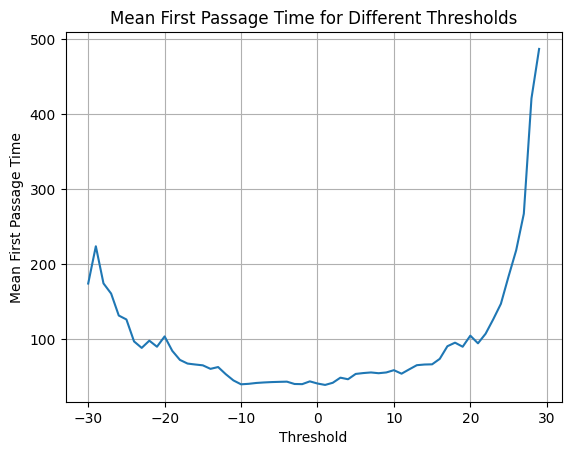

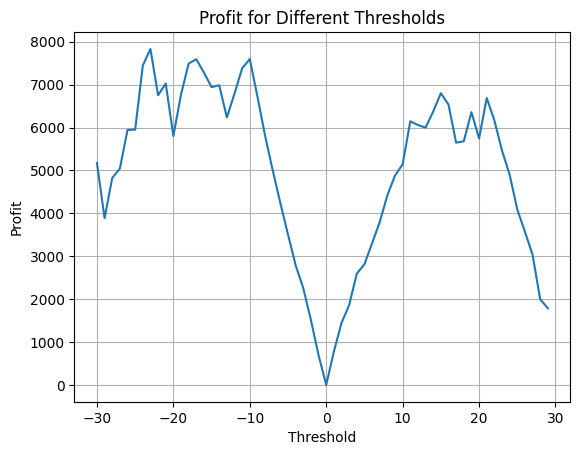

In [354]:
def calculate_mfpt(time_series, threshold):
    crossing_times = []
    current_value = None

    for i, value in enumerate(time_series):
        if current_value is None:
            current_value = value
            continue

        if (current_value <= threshold and value > threshold) or (current_value >= threshold and value < threshold):
            crossing_times.append(i)
        
        current_value = value

    if len(crossing_times) < 2:
        return None

    passage_times = [crossing_times[i + 1] - crossing_times[i] for i in range(len(crossing_times) - 1)]
    return sum(passage_times) / len(passage_times)


t = df.Option_Price - df.Call_Price

time_series = t
thresholds = range(-30, 30, 1)
profits = []
mfpts = []

for threshold in thresholds:
    mfpt = calculate_mfpt(time_series, threshold)
    print(f"MFPT for threshold {threshold}: {mfpt}")
    mfpts.append(mfpt)
    profits.append((30000/mfpt) * abs(threshold))

# Plot MFPTs
plt.plot(thresholds, mfpts)
plt.xlabel('Threshold')
plt.ylabel('Mean First Passage Time')
plt.title('Mean First Passage Time for Different Thresholds')
plt.grid(True)
plt.show()

# Plot Profits
plt.plot(thresholds, profits)
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title('Profit for Different Thresholds')
plt.grid(True)
plt.show()